In [3]:
import binascii
import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
def file2bin(input_file, output_bin):
    '''
        Creates a binary file as output from a given input file with no particular format.
            Inputs:
                -input_file: [str] source file to transfer (any extension will work [eg: .jpg, .png, .mp3, .pptx, ...])
                -output_bin: [str] binary file created from the input file codification.

            Outputs:
                -bin_string: [str] binary string with the information of the input file.
    '''

    # Definition of files handler.
    writer = open(output_bin, 'w')

    # reading the contents of the input file 
    with open(input_file, 'rb') as f:
        content = f.read()

    # Changing the contents from the input file format to hex codification.
    bin_string = binascii.hexlify(content)
    #print(bin_string[0:100])
    
    bin_string = bin(int(bin_string, 16))[2:]
    writer.write(f'{bin_string}')
    print(f'[INFO] Hex file successfully created as: {output_bin}')

    # Closing files.
    f.close()
    writer.close()
    
    return bin_string

In [5]:
def bin2file(bin_string, output_file):

    '''
    Converts from an input hex file to a selected format output file. 
        Inputs:
            -bin_string: [str] binary string received from an external source.
            -output_file: [str] result of the re transformation of binary data to a particular file.
    '''

    with open(output_file, 'wb') as fout:
        # Re-transforming the binary string to data
        bin_string = hex( int(bin_string, 2) )[2:]
        fout.write(binascii.unhexlify(bin_string))
        fout.close()

    print(f'[INFO] New file created succesfully. Name: {output_file}')

In [6]:
def extension_handler(input_file):
    '''
        This function gets the extension from the input file and creates the output_file with the same extension
            Inputs:
                -input_file: [str] hardcoded input file from the main function (including its extension)
            Outputs: 
                -output_bin: [str] path and name (hardcoded) to the output binary string to transmit
                -output_file [str] path and name (with the same extension as the input) to the received file.
    '''
    # Splitting the path given as input
    path = os.path.split(input_file)
    output_path = path[0]
    extension = path[1]
    print(extension)
    # Getting the extension of the file given as input
    extension = extension.split('.')
    extension = extension[1]

    # Output paths definition
    output_bin = os.path.join(output_path, 'output_bin.txt')
    output_file = os.path.join(output_path, f'output_file.{extension}')

    return output_bin, output_file

In [7]:
def BSC_str(transmitted_bits, pe):
    transmitted_bits = list(transmitted_bits)
    print(len(transmitted_bits))
    for i in range(len(transmitted_bits)):
        rand = random.random()
        if(rand < pe):
            if transmitted_bits[i] == "1":
                transmitted_bits[i] = "0"
            else:
                transmitted_bits[i] = "1"
    return ''.join(transmitted_bits)

In [20]:
def BSC(transmitted_bits, pe):
    """ Binary Symmetric Channel """ 
    received_bits = transmitted_bits
    #print(received_bits[0:100])
    for i in range(len(transmitted_bits)):
        rand = random.random()
        if rand < pe:
            #print(i)
            to_check = random.randint(0,1)
            if to_check == 1:
                to_change= 0
            else:
                to_change = 1
            received_bits[i] = np.where(received_bits[i]==to_check, to_change, received_bits[i])
    return received_bits

In [9]:
def channelEncoder(string_bits):
    """ Channel encoder """
    #string_in = string_bits[0:103]
    bit_sequence = list(string_bits)
    bit_sequence = [int(bit) for bit in bit_sequence]

    #En encoder_output se tendra el result final cuando se termine la codificacion de todos los conjuntos de k bits
    encoder_output = np.empty([1,6], int)
    #Define la matriz generadora G
    G = np.array([[1, 1, 0, 1, 0, 0], [ 0, 1, 1, 0, 1, 0], [ 1, 0, 1, 0, 0, 1]])
    #Limites para recorrer el arreglo
    k = 3
    n = 0
    m = 3

    #Guarda la cantidad de zeroes agregados en la bit_sequence en caso de que no sea múltiplo de k = 3
    zeroes = 0

    while(len(bit_sequence)%k != 0): #Revisa que no vayan a quedar vectores con menos de k elementos
        bit_sequence.append(0)
        zeroes+=1

    #Recorre todo el arreglo de entrada
    while n < len(bit_sequence):
        #Se obtienen los k = 3 bits para codificar
        encoder_input = np.array([bit_sequence[n:m]])
        multiplicacion = encoder_input@G
            
        for i in multiplicacion[0]:
            multiplicacion[0][i] = multiplicacion[0][i] % 2

        if n == 0: #Inicizaliza el np.array
            encoder_output= multiplicacion
        else: #apila los demas resultados
            encoder_output = np.vstack([encoder_output, multiplicacion])
        n+=k
        m+=k

    string = np.array_str(encoder_output)
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace(' ', '')
    string = string.replace('\n', '')

    return encoder_output, zeroes, string_bits



In [10]:
def channelDecoder(encoder_output, string):
    """ Channel decoder """
    H = np.array([[1, 0, 0],[ 0, 1, 0],[ 0, 0, 1],[ 1, 1, 0],[ 0, 1, 1],[ 1, 0, 1]])

    # To go through all the 6 bits received. 6 bits are obtained from the matrix multiplication m*G
    n = 0
    m = 6


    sindromes = np.empty([1,3], int)
    decoder_output = []
    # Recorremos todos los bits codificados para hallar el sindrome con S = vH
    while n < encoder_output.shape[0]:
        #print(encoder_output[n])
        multiplicacion_sindromes = np.remainder(encoder_output[n]@H, 2) #Multiplicacion de matrices y modulo 2

        if (n==0):
            sindromes = multiplicacion_sindromes 
        else:
            sindromes = np.vstack([sindromes, multiplicacion_sindromes])

        #Simple error correction with syndrome
        for i in range(m): #
            #print(H[i], multiplicacion_sindromes)
            if (H[i] == multiplicacion_sindromes).all():
                if encoder_output[n][i] == 1:
                    print(f"correccion en file {n}, columna {i}")
                    encoder_output[n][i] = 0
                else:
                    encoder_output[n][i] = 1
                    print(f"correccion en file {n}, columna {i}")
        print(channelError(multiplicacion_sindromes))
        
        # Get the last 3 bits which are packaged according to the G matrix
        decoder_output.extend(encoder_output[n][3:6].tolist())
        # get the next 6 bits
        n+=1

    #for i in range(len(sindromes)):
    #    print(sindromes[i], encoder_output[i])
        
        
    decoder_outputStr = ''.join(str(bit) for bit in decoder_output)
    diff = len(decoder_outputStr) - len(string)
    if diff != 0:
        decoder_outputStr = decoder_outputStr[:-diff]
    
    return decoder_outputStr

In [43]:
def channelError(syndrome):
    H = np.array([[1, 0, 0],[ 0, 1, 0],[ 0, 0, 1],[ 1, 1, 0],[ 0, 1, 1],[ 1, 0, 1]])
    dim = len(H)
    errorArray = np.zeros(dim)
    counter = 0
    errorLocation = 0
    for row in H:
        comparison = row == syndrome
        if comparison.all():
            errorLocation = counter
        counter = counter+1
    if errorLocation != 0:
        errorArray[errorLocation] = 1
    
    return errorArray

In [166]:
def main():
    input_file = "./captura.bmp"

    # setting the output files to the same location and extension as the input file
    output_bin, output_file = extension_handler(input_file)

    # Transforming the input file to binary
    bin_string = file2bin(input_file, output_bin)
    

    trans_bin1, zeroes, string = channelEncoder(bin_string)

    trans_bin = BSC(trans_bin1, 0.003)
    
    #for i in range(len(trans_bin)):
    #    print(i, trans_bin[i], trans_bin1[i])
    #    if (trans_bin[i] != trans_bin1[i]).all():
    #        print(i)

    #print(string)
    rec_bin = channelDecoder(trans_bin, string)

    lista = []

    for i in range(len(string)):
        if string[i] != rec_bin[i]:
            lista.append(i)
            #print(i)
    
    print(f'[INFO] Error not fixed: {len(lista)}')
    lista2 = []


    # Transforming the binary string to an output file
    bin2file(rec_bin,output_file)

if __name__ == '__main__':
    main()

captura.bmp
[INFO] Hex file successfully created as: ./output_bin.txt
[INFO] Error not fixed: 134
[INFO] New file created succesfully. Name: ./output_file.bmp


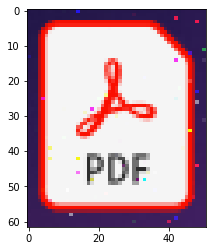

In [167]:
img = mpimg.imread('output_file.bmp')

imgplot = plt.imshow(img)

captura.bmp
[INFO] Hex file successfully created as: output_bin.txt
102287
[INFO] Error not fixed: 266
[INFO] New file created succesfully. Name: output_file.bmp


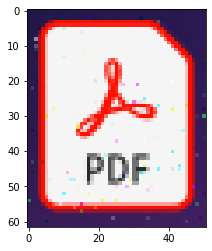

In [163]:
def main():
    input_file = "captura.bmp"

    output_bin, output_file = extension_handler(input_file)

    bin_string = file2bin(input_file, output_bin)

    trans_bin = BSC_str(bin_string, 0.003)

    lista = []

    for i in range(len(trans_bin)):
        if (trans_bin[i] != bin_string[i]):
            lista.append(i)

    
    print(f'[INFO] Error not fixed: {len(lista)}')


    # Transforming the binary string to an output file
    bin2file(trans_bin,output_file)

if __name__ == '__main__':
    main()
    
img = mpimg.imread('output_file.bmp')

imgplot = plt.imshow(img)


    